# Analyzing job vacancies

### Table of contents
&nbsp;&nbsp;&nbsp;&nbsp;[Dataset loading](#dataset-loading)  
  
&nbsp;&nbsp;&nbsp;&nbsp;[Standardizing values in dataset](#data-standardizing)  
  
&nbsp;&nbsp;&nbsp;&nbsp;[Salary distribution analysis](#salary-distribution)  
  
&nbsp;&nbsp;&nbsp;&nbsp;[Analysis of experience needed](#experience-analysis)  
  
&nbsp;&nbsp;&nbsp;&nbsp;[Skills requirements analysis](#skills-analysis)  
  
&nbsp;&nbsp;&nbsp;&nbsp;[Geographical analysis (with map visualisation experiments)](#map-visual)

In [49]:
from datetime import datetime as dt

import numpy as np
print('Numpy version:', np.__version__)
import pandas as pd
print('Pandas version:', pd.__version__)
import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
print('Seaborn version:', sns.__version__)

import nltk
print('nltk version:', nltk.__version__)

import folium
print('Folium version:', folium.__version__)

from tqdm import tqdm

import statsmodels.api as sm

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1
nltk version: 3.7
Folium version: 0.13.0


### Dataset loading<a class="anchor" id="dataset-loading"></a>

In [2]:
filename = 'datasets/vacancies-no-duplicates-augm-2022-11-27.csv'
df = pd.read_csv(filename, index_col=0)
df.head()

,vacancy_name,company_name,address,latitude,longitude,salary_from,salary_to,salary_currency,salary_gross,publication_time,last_changed,schedule,req,resp,cond,full_description,key_skills,experience_needed
vacancy_id,,,,,,,,,,,,,,,,,,
72750262,Ведущий аналитик (качество данных\Data quality),Банк ВТБ (ПАО),"Москва, Пресненская набережная, 10с1",55.748914,37.535466,NaN,NaN,NaN,NaN,2022-11-23 07:08:44,2022-11-23 07:08:44,FULL_DAY,Высшее образование. Опыт работы в качестве ана...,"Мониторинг качества данных, организация процес...",Трудоустройство согласно Законодательству. Кон...,Обязанности: участие в проектах по внедрению ...,Анализ данных;Аналитическое мышление;Data quality,3–6 лет
72674818,Аналитик данных,Городские информационные системы,NaN,NaN,NaN,120000.0,180000.0,RUR,False,2022-11-27 09:36:56,2022-11-27 10:21:43,FULL_DAY,"...заданий, валидация данных. Особенности OLAP...","...SQL-запросы, хранимые процедуры, вьюшки. Ви...",Удалённая работа. Уютный коллектив. Минимум бю...,Мы сейчас переносим отчетность из SAP систем н...,Английский язык;Работа в команде;SQL;PostgreSQ...,3–6 лет
72527010,Аналитик базы данных,Вектор,"Красногорск, бульвар Строителей, 4к1",55.814462,37.385412,70000.0,NaN,RUR,False,2022-11-27 08:32:14,2022-11-27 09:21:16,FULL_DAY,Умение обрабатывать большие объемы данных и ви...,...данных и подготовка информации для расчетов...,"График: 5/2 , с 8:00 до 17:00,выходные: суббот...","Мы группа компаний ""Truck Radar"" - лидеры на р...",Базы данных;Работа с базами данных;Прогнозиров...,1–3 года
70839955,Аналитик данных (Data Office),"VK, ВКонтакте",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-27 07:02:13,2022-11-27 07:02:13,FULL_DAY,Понимаете основные продуктовые и бизнес-метрик...,Плотно взаимодействовать на ежедневной основе ...,NaN,Мы занимаемся аналитикой экосистемных продукто...,SQL;Python;Математическая статистика;BI;Аналитика,1–3 года
72943931,Аналитик ГЕО данных,ГАУ ИНСТИТУТ ГЕНПЛАНА МОСКВЫ,"Москва, 2-я Брестская улица, 2/14",55.769641,37.593121,NaN,NaN,NaN,NaN,2022-11-25 13:00:40,2022-11-26 19:50:13,FULL_DAY,Хорошее знание инструментов WEB-картографии и ...,Интеграция данных из различных источников в ед...,"Стабильная заработная плата, включающая оклад,...",Обязанности: • Создание и развитие корпоративн...,QGIS;ArcGIS;ГИС;SQL;PostgreSQL,1–3 года


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435 entries, 72750262 to 71923183
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   vacancy_name       435 non-null    object 
 1   company_name       435 non-null    object 
 2   address            212 non-null    object 
 3   latitude           208 non-null    float64
 4   longitude          208 non-null    float64
 5   salary_from        44 non-null     float64
 6   salary_to          37 non-null     float64
 7   salary_currency    60 non-null     object 
 8   salary_gross       60 non-null     object 
 9   publication_time   435 non-null    object 
 10  last_changed       435 non-null    object 
 11  schedule           435 non-null    object 
 12  req                433 non-null    object 
 13  resp               434 non-null    object 
 14  cond               393 non-null    object 
 15  full_description   434 non-null    object 
 16  key_skills    

Here we can see many Nan values. These Nans are mostly in salary and location parts. For now we can't do anything with them. Maybe later we'll find a way to deal with those Nans

### Standardizing values in dataset <a class="anchor" id="data-standardizing"></a>

To perform analysis we have to be sure that numerical fields are consistent and homogenious. Let's check if all salary fields are in same currency

In [4]:
df['salary_currency'].value_counts()

RUR    57
USD     3
Name: salary_currency, dtype: int64

We have 2 currencies here and the majority of values are in RUR. So we need to recalculate USD to RUR using current RUR/USD ratio. Let's assume it is equal 69.0 RUR/USD. As we have only USD as foreign currency here we will use simple variable to convert values instead of dictionary.  
Moreover as we have `salary_gross` column we need to check also if there are same values in there.

In [5]:
df['salary_gross'].value_counts()

False    41
True     19
Name: salary_gross, dtype: int64

And to get comparable results we have to apply personal income tax ratio (it's 13% in Russia) to rows with `salary_gross`==True.  
We will create additional columns which will contain "cleaned" values (i.e. values we can compare to each other)

In [6]:
# converting currencies to rur and applying personal income tax (PIT) to salary marked as gross
#currency_ratios = {'USD': 69.0, 'EUR': 75.0}
rur_usd_ratio = 69.0
pit_ratio = 0.13
df['salary_from_rur'] = df.apply(lambda x: x['salary_from'] if x['salary_currency'] == 'RUR' else x['salary_from']*rur_usd_ratio, axis=1)
df['salary_to_rur'] = df.apply(lambda x: x['salary_to'] if x['salary_currency'] == 'RUR' else x['salary_to']*rur_usd_ratio, axis=1)
df[df['salary_currency'] == 'USD']

,vacancy_name,company_name,address,latitude,longitude,salary_from,salary_to,salary_currency,salary_gross,publication_time,last_changed,schedule,req,resp,cond,full_description,key_skills,experience_needed,salary_from_rur,salary_to_rur
vacancy_id,,,,,,,,,,,,,,,,,,,,
72227204,Аналитик данных,ReleaseBand (Шумков Денис Александрович),NaN,NaN,NaN,1000.0,NaN,USD,False,2022-11-11 11:58:39,2022-11-25 02:53:29,FULL_DAY,опыт работы продуктовым аналитиком от 2х лет. ...,применять инструменты и методы анализа данных ...,"отсутствие бюрократии, открытость, быстрое при...","Мы Gamebeat, амбициозная студия разработки онл...",Английский — B1 — Средний;Tableau;SQL;Power BI...,1–3 года,69000.0,NaN
71933443,Data Scientist to Armenia,"Агентство 21 век, КЦ",NaN,NaN,NaN,NaN,5600.0,USD,True,2022-11-03 15:15:38,2022-11-23 10:00:43,FULL_DAY,...data science. Understanding of data enginee...,Collaboration with data science and technology...,Medical insurance.,We are looking for a Data Scientist to join an...,Python;Deep Learning;Machine Learning;Tensorfl...,3–6 лет,NaN,386400.0
71864985,Senior Risk Data Scientist for a global FinTec...,Gauss Money,Нью-Йорк,40.714606,-74.0028,NaN,6000.0,USD,True,2022-11-02 08:27:09,2022-11-27 08:57:22,FULL_DAY,"Initiative, courage, and self-sufficiency. Enj...",...of behavioral and transactional data. Own R...,NaN,"We are reinventing $1T (yes, trillion ) US cre...",Английский — C1 — Продвинутый;Python;Английски...,3–6 лет,NaN,414000.0


In [7]:
# converting all salaries to net value
df['net_income_from_rur'] = df.apply(lambda x: np.round(x['salary_from_rur']*(1-pit_ratio), 2) if x['salary_gross'] else x['salary_from_rur'], axis=1)
df['net_income_to_rur'] = df.apply(lambda x: np.round(x['salary_to_rur']*(1-pit_ratio), 2) if x['salary_gross'] else x['salary_to_rur'], axis=1)
df[df['salary_gross'] == True].head()

,vacancy_name,company_name,address,latitude,longitude,salary_from,salary_to,salary_currency,salary_gross,publication_time,...,req,resp,cond,full_description,key_skills,experience_needed,salary_from_rur,salary_to_rur,net_income_from_rur,net_income_to_rur
vacancy_id,,,,,,,,,,,,,,,,,,,,,
72785935,Геоаналитик / ГИС Аналитик / Аналитик данных,ПК НПК,"Москва, улица Гашека, 6",55.768345,37.590533,NaN,180000.0,RUR,True,2022-11-26 07:45:31,...,"Опыт структурирования данных, подготовки данны...",АО РНПК (Российская Национальная Перестраховоч...,Прием на дистанционную работу по трудовому дог...,АО РНПК (Российская Национальная Перестраховоч...,SQL;MS PowerPoint;MS SQL;MS Access;Python;Прог...,3–6 лет,NaN,180000.0,NaN,156600.0
71811656,Аналитик данных,Автомакон,NaN,NaN,NaN,110000.0,250000.0,RUR,True,2022-11-25 09:52:37,...,Уверенные знания SQL и опыт работы с базами да...,"Извлечение, преобразование, загрузка данных и ...","Возможность удаленной работы, а также в офисе ...",ГК «Автомакон» – системный интегратор IT-решен...,Python;Pandas;SQL;ML,1–3 года,110000.0,250000.0,95700.0,217500.0
72947996,Data аналитик (Аналитик данных),BestDoctor,NaN,NaN,NaN,130000.0,NaN,RUR,True,2022-11-25 14:13:30,...,Nice to have! Знание Python будут преимущество...,...выступать заказчиком доработок со стороны а...,Удаленный формат работы (будем рады тебя видет...,BestDoctor — экосистема медицинских и страховы...,SQL;Python;Tableau;Power BI,1–3 года,130000.0,NaN,113100.0,NaN
71204490,Аналитик данных,Россельхозбанк,NaN,NaN,NaN,NaN,140000.0,RUR,True,2022-11-14 07:04:13,...,Средне профессиональное/ неоконченное высшее/ ...,Развитие и поддержка хранилища на базе SQL Ser...,Уровень заработной платы определяется по итога...,Мы команда Контакт-центра Россельхозбанка. Еже...,SQL;DAX;Power BI;Работа с большим объемом инфо...,1–3 года,NaN,140000.0,NaN,121800.0
71502317,Программист-аналитик данных телепроектов,Первый канал,"Москва, улица Академика Королёва, 12",55.822883,37.606281,62000.0,NaN,RUR,True,2022-11-14 07:51:01,...,"...данных, телевизионная социология, математич...",Написание запросов с помощью языков программир...,Работа в ТТЦ Останкино. Испытательный срок 3 м...,Обязанности: Работа с базами данных 1С и Med...,SQL;Python;MS PowerPoint;Анализ данных;Java,1–3 года,62000.0,NaN,53940.0,NaN


Now we have comparable salary values (if filled). Let's see the distribution of net salaries

### Salary distribution analysis<a class="anchor" id="salary-distribution"></a>

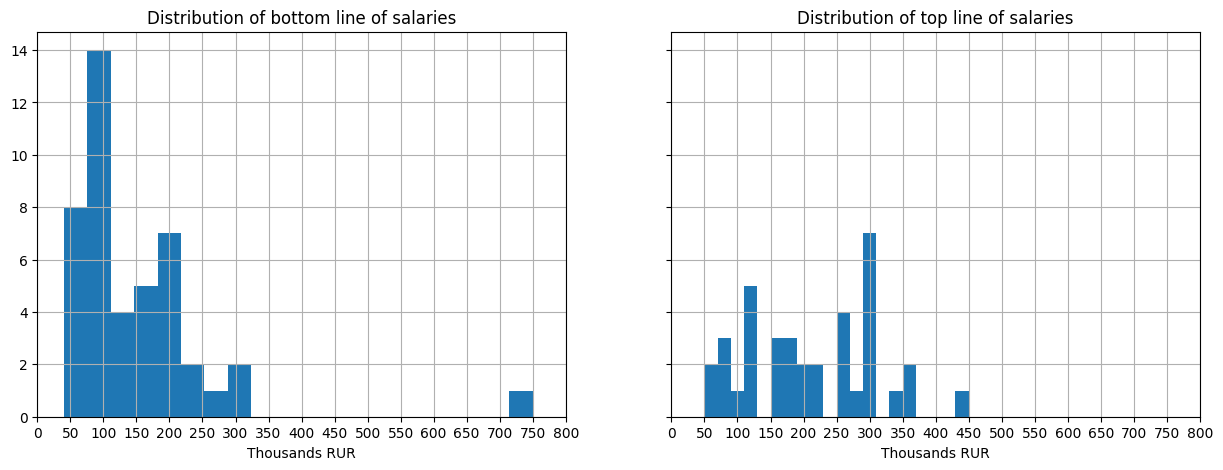

In [8]:
bins = 20
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
df[df['net_income_from_rur'].notna()]['net_income_from_rur'].hist(bins=bins, ax=axs[0])
axs[0].set_title('Distribution of bottom line of salaries')
axs[0].set_xlabel('Thousands RUR')
df[df['net_income_to_rur'].notna()]['net_income_to_rur'].hist(bins=bins, ax=axs[1])
axs[1].set_title('Distribution of top line of salaries')
axs[1].set_xlabel('Thousands RUR')
axs[1].set_xticks(range(0,801000,50000));
axs[1].set_xticklabels(range(0,801,50));

In [10]:
print('Median bottom-line level ({} / {} observations): '.format(len(df[df['net_income_from_rur'].notna()]), len(df)), np.median(df[df['net_income_from_rur'].notna()]['net_income_from_rur'].to_numpy()))
print('Median top-line level ({} / {} ) observations:   '.format(len(df[df['net_income_to_rur'].notna()]), len(df)), np.median(df[df['net_income_to_rur'].notna()]['net_income_to_rur'].to_numpy()))

Median bottom-line level (44 / 435 observations):  111550.0
Median top-line level (37 / 435 ) observations:    200100.0


We see that most of vacancies salary begins at 50'000 RUR with modal value near 110'000 RUR. There is also an outlier proposal with more than 700'000 RUR as bottom-line salary level.  
The top-line levels distributed more unifofrmly mostly within 50'000-370'000 RUR range

In [11]:
print('Num of companies reported both (bottom AND top) salary levels:   ', len(df[df['net_income_from_rur'].notna() & df['net_income_to_rur'].notna()]))
print('Num of companies reported only one (bottom OR top) salary level: ', len(df[df['net_income_from_rur'].notna() | df['net_income_to_rur'].notna()]))

Num of companies reported both (bottom AND top) salary levels:    21
Num of companies reported only one (bottom OR top) salary level:  60


We have only 60 companies out of 435 which reported salary level (bottom-line or top-line), including 21 of them reported both.  
This is not enough to make strong assumptions about distribution and build and train reliable ML model. But we can try to determine some dependencies which can help us to forecast the salary level.  
Now we want to see what the requirements for candidates (experience and key skills) are

### Analysis of experience needed<a class="anchor" id="experience-analysis"></a>

Here we want to see if there is any difference between offered salary level and required experience

In [12]:
df['experience_needed'].value_counts()

1–3 года        237
3–6 лет         176
более 6 лет      12
не требуется     10
Name: experience_needed, dtype: int64

In [13]:
cat_dtype = pd.CategoricalDtype(categories=['не требуется', '1–3 года', '3–6 лет', 'более 6 лет'], ordered=True)
df['experience_needed_cat'] = df['experience_needed'].astype(cat_dtype)

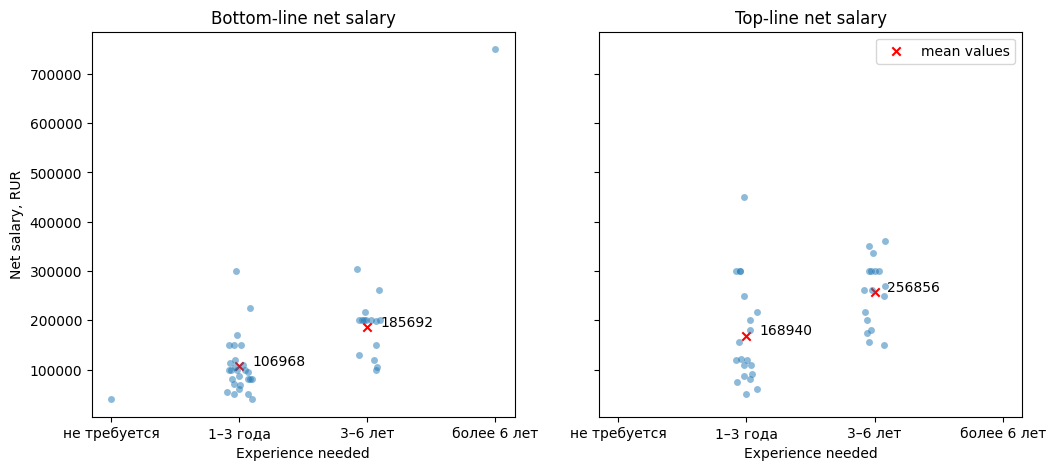

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
sns.stripplot(data=df, x='experience_needed_cat', y='net_income_from_rur', alpha=0.5, ax=axs[0]) # used instead catplot as catplot is figure-level
sns.stripplot(data=df, x='experience_needed_cat', y='net_income_to_rur', alpha=0.5, ax=axs[1])
axs[0].set_xlabel('Experience needed')
axs[0].set_ylabel('Net salary, RUR')
axs[0].set_title('Bottom-line net salary')
mean_3_years_low = df.loc[df['experience_needed_cat'] == '1–3 года', 'net_income_from_rur'].mean()
mean_6_years_low = df.loc[df['experience_needed_cat'] == '3–6 лет', 'net_income_from_rur'].mean()
axs[0].scatter([1, 2], [mean_3_years_low, mean_6_years_low], marker='x', color='r')
axs[0].text(x=1.1, y=mean_3_years_low+2e3, s=f'{mean_3_years_low:.0f}')
axs[0].text(x=2.1, y=mean_6_years_low+2e3, s=f'{mean_6_years_low:.0f}')
mean_3_years_high = df.loc[df['experience_needed_cat'] == '1–3 года', 'net_income_to_rur'].mean()
mean_6_years_high = df.loc[df['experience_needed_cat'] == '3–6 лет', 'net_income_to_rur'].mean()
axs[1].scatter([1, 2], [mean_3_years_high, mean_6_years_high], marker='x', color='r', label='mean values')
axs[1].text(x=1.1, y=mean_3_years_high+2e3, s=f'{mean_3_years_high:.0f}')
axs[1].text(x=2.1, y=mean_6_years_high+2e3, s=f'{mean_6_years_high:.0f}')
axs[1].set_xlabel('Experience needed')
axs[1].set_title('Top-line net salary')
axs[1].legend();

We can see that there is a dependency between experience and both bottom- and top-line salaries in '1-3 years of experience' and '3-6 years of experience' groups. Values in 'no experience' and 'more than 6 years experience' are single and do not provide significant information although they are in line with the general trend  
Let's determine the statistical significance of difference between means. We should use 2-way independent t-test

In [53]:
print('p-value for H0 (mean values are equal) is ', sm.stats.ttest_ind(
    df.loc[(df['experience_needed_cat'] == '1–3 года') & df['net_income_from_rur'].notna(), 'net_income_from_rur'], 
    df.loc[(df['experience_needed_cat'] == '3–6 лет') & df['net_income_from_rur'].notna(), 'net_income_from_rur']
)[1])

p-value for H0 (mean values are equal) is  0.00010060122947426791


Therefore we can consider the difference between salary levels of different experience groups as statistically significant

### Skills requirements analysis<a class="anchor" id="skills-analysis"></a>

The purposes of skills analysis are:  
* to determine what skills are most often mentioned in vacancies requirements
* to find if there is any relation between required skills and salary level  
  
First we will transform the string representation of required skills to frequencies dataframe. Then we will have to make a postprocessing as identical skills can be formulated by different ways

In [56]:
df['key_skills'].value_counts(dropna=False)

NaN                                                                                                                                                     58
Python;SQL                                                                                                                                               7
Оценка рисков;MS PowerPoint;Статистический анализ;Управление рисками;Математическое моделирование;PD, LGD, EAD;SQL;Портфельные риски;кредитные риски     3
Python;SQL;pyspark;airflow;анализа A/B;Разработка поисковых технологий                                                                                   3
Английский — B2 — Средне-продвинутый                                                                                                                     3
                                                                                                                                                        ..
Python;SQL;Аналитическое мышление;Анализ конкурентной среды;Исследован

Splitting skills strings and calculating frequencies

In [57]:
key_skills_freq = {}
for skills in tqdm(df['key_skills']):
    if type(skills) == type(''):
        for skill in skills.lower().split(';'):
            if key_skills_freq.get(skill, None) is None:
                key_skills_freq[skill] = 0
            key_skills_freq[skill] += 1
df_skills = pd.DataFrame(pd.Series(key_skills_freq), columns=['frequency']).reset_index().rename(columns={'index': 'skill'})
df_skills['skill_class'] = np.nan # to mark similar skills
df_skills.head()

100%|██████████| 435/435 [00:00<00:00, 144539.51it/s]


,skill,frequency,skill_class
0,анализ данных,97,NaN
1,аналитическое мышление,60,NaN
2,data quality,4,NaN
3,английский язык,29,NaN
4,работа в команде,15,NaN


We can see many similar skills but formulated by slightly different words. So we'll process some of most popular values to perform a frequency analysis and then look at 10 most frequent skills

In [104]:
import re

patterns = {
    r'sql': 'sql',
    r'статис': 'statistics',
    r'data analysis': 'analysis',
    r'анали': 'analysis',
    r'machine learning': 'ml',
    r'англ': 'english',
}

for row in df_skills.iterrows():
    for key, value in patterns.items():
        if re.search(key, row[1]['skill']):
            df_skills.loc[row[0], 'skill_class'] = value
            break
        else:
            df_skills.loc[row[0], 'skill_class'] = df_skills.loc[row[0], 'skill']

,skill,frequency,skill_class
0,анализ данных,97,analysis
1,аналитическое мышление,60,analysis
2,data quality,4,data quality
3,английский язык,29,english
4,работа в команде,15,работа в команде
...,...,...,...
472,dl,1,dl
473,solr,1,solr
474,elasticsearch,1,elasticsearch
475,credit risk,1,credit risk


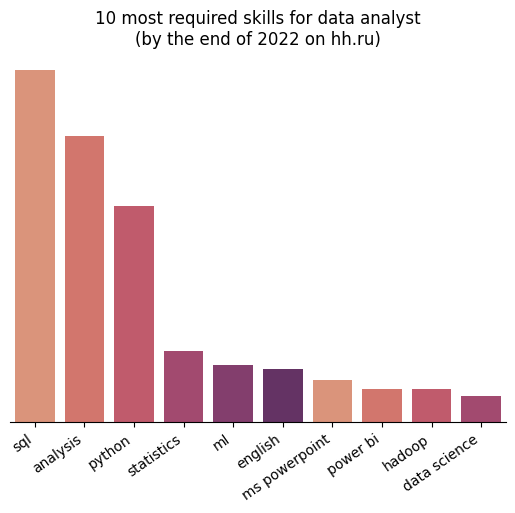

In [125]:
sns.barplot(data=df_skills.groupby('skill_class')['frequency'].sum().sort_values(ascending=False).nlargest(10).reset_index(), x='skill_class', y='frequency', palette=sns.color_palette("flare"))
ax = plt.gca()
ax.set_title('10 most required skills for data analyst\n(by the end of 2022 on hh.ru)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.yaxis.set_visible(False)
ax.spines[['left', 'top', 'right']].set_visible(False)

### Geographical analysis (with map visualisation experiments)<a class="anchor" id="map-visual"></a>

We have near 200 companies reported their coordinates. Let's see where these are located

In [17]:
vacancies_msk = df[(df['latitude'].notna()) & (df['longitude'].notna())]
vacancies_msk.head()

,vacancy_name,company_name,address,latitude,longitude,salary_from,salary_to,salary_currency,salary_gross,publication_time,...,resp,cond,full_description,key_skills,experience_needed,salary_from_rur,salary_to_rur,net_income_from_rur,net_income_to_rur,experience_needed_cat
vacancy_id,,,,,,,,,,,,,,,,,,,,,
72750262,Ведущий аналитик (качество данных\Data quality),Банк ВТБ (ПАО),"Москва, Пресненская набережная, 10с1",55.748914,37.535466,NaN,NaN,NaN,NaN,2022-11-23 07:08:44,...,"Мониторинг качества данных, организация процес...",Трудоустройство согласно Законодательству. Кон...,Обязанности: участие в проектах по внедрению ...,Анализ данных;Аналитическое мышление;Data quality,3–6 лет,NaN,NaN,NaN,NaN,3–6 лет
72527010,Аналитик базы данных,Вектор,"Красногорск, бульвар Строителей, 4к1",55.814462,37.385412,70000.0,NaN,RUR,False,2022-11-27 08:32:14,...,...данных и подготовка информации для расчетов...,"График: 5/2 , с 8:00 до 17:00,выходные: суббот...","Мы группа компаний ""Truck Radar"" - лидеры на р...",Базы данных;Работа с базами данных;Прогнозиров...,1–3 года,70000.0,NaN,70000.0,NaN,1–3 года
72943931,Аналитик ГЕО данных,ГАУ ИНСТИТУТ ГЕНПЛАНА МОСКВЫ,"Москва, 2-я Брестская улица, 2/14",55.769641,37.593121,NaN,NaN,NaN,NaN,2022-11-25 13:00:40,...,Интеграция данных из различных источников в ед...,"Стабильная заработная плата, включающая оклад,...",Обязанности: • Создание и развитие корпоративн...,QGIS;ArcGIS;ГИС;SQL;PostgreSQL,1–3 года,NaN,NaN,NaN,NaN,1–3 года
72785935,Геоаналитик / ГИС Аналитик / Аналитик данных,ПК НПК,"Москва, улица Гашека, 6",55.768345,37.590533,NaN,180000.0,RUR,True,2022-11-26 07:45:31,...,АО РНПК (Российская Национальная Перестраховоч...,Прием на дистанционную работу по трудовому дог...,АО РНПК (Российская Национальная Перестраховоч...,SQL;MS PowerPoint;MS SQL;MS Access;Python;Прог...,3–6 лет,NaN,180000.0,NaN,156600.0,3–6 лет
72432302,Аналитик баз данных,Современные коммуникационные технологии,"Москва, Сокольническая линия, метро Румянцево",55.633028,37.441395,100000.0,150000.0,RUR,False,2022-11-25 16:16:20,...,Коммуникация с потребителями выгружаемой отчет...,Работу в комфортном офисе в Бизнес Парке «Румя...,"Здравствуй, наш будущий коллега! В нашей дружн...",Пользователь ПК;CRM;Аналитическое мышление;Exc...,3–6 лет,100000.0,150000.0,100000.0,150000.0,3–6 лет


##### Showing companies as simple marks on map

In [28]:
col_latitude, col_longitude = 3, 4

moscow_map = folium.Map(location=[vacancies_msk.iloc[0, col_latitude], df.iloc[0, col_longitude]], zoom_start=11) # anchoring map to first vacancy coordinates
# , width='100%', height='100%', zoom_control=False, min_zoom=11, max_zoom=11 # lock zoom
job_places_msk = folium.map.FeatureGroup()
for n in range(len(vacancies_msk)):
    job_places_msk.add_child(folium.features.CircleMarker([vacancies_msk.iloc[n, col_latitude], vacancies_msk.iloc[n, col_longitude]], radius=3, color='red', fill_color='red'))

In [29]:
moscow_map.add_child(job_places_msk)
moscow_map

##### Showing density of companies as heatmap

In [83]:
from folium.plugins import HeatMap

In [86]:
data = []
for n in range(len(vacancies_msk)):
    data.append([vacancies_msk.iloc[n, col_latitude], vacancies_msk.iloc[n, col_longitude]])
#data.pop(3)

In [87]:
HeatMap(data).add_to(folium.FeatureGroup(name='Heat map').add_to(moscow_map))
folium.LayerControl().add_to(moscow_map)
moscow_map

In [88]:
vacancies_msk_with_salary = vacancies_msk[(vacancies_msk['net_income_from_rur'].notna()) | (df['net_income_to_rur'].notna())]
vacancies_msk_with_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 72527010 to 71864985
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   vacancy_name           34 non-null     object  
 1   company_name           34 non-null     object  
 2   address                34 non-null     object  
 3   latitude               34 non-null     float64 
 4   longitude              34 non-null     float64 
 5   salary_from            25 non-null     float64 
 6   salary_to              21 non-null     float64 
 7   salary_currency        34 non-null     object  
 8   salary_gross           34 non-null     object  
 9   publication_time       34 non-null     object  
 10  last_changed           34 non-null     object  
 11  schedule               34 non-null     object  
 12  req                    34 non-null     object  
 13  resp                   34 non-null     object  
 14  cond                   32 non-n

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_17660\281911330.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vacancies_msk_with_salary = vacancies_msk[(vacancies_msk['net_income_from_rur'].notna()) | (df['net_income_to_rur'].notna())]


##### Showing distribution of salary on map

To show on map distribution of salaries (only 34 entries) we will convert salary data to average value as follows:  
- if there is only bottom- or top-level salary then leave it as it is
- if there is bottom- AND top-level salary then calculate simple average value  
  
Then we will use log function to scale down the diversity between salary levels

In [103]:
def calc_avg_salary(x):
    array = np.array([x['net_income_from_rur'], x['net_income_to_rur']])
    m = [~np.isnan(a) for a in array]
    return np.mean(array, where=m)

In [105]:
vacancies_msk_with_salary['avg_salary'] = vacancies_msk_with_salary.apply(calc_avg_salary, axis=1)
net_min_salary_weights = list(vacancies_msk_with_salary['avg_salary'].apply(np.log)) # / vacancies_msk_with_salary['avg_salary'].max())
moscow_map = folium.Map(location=[vacancies_msk_with_salary.iloc[0, col_latitude], vacancies_msk_with_salary.iloc[0, col_longitude]], zoom_start=11)
data = []
for n in range(len(vacancies_msk_with_salary)):
    data.append([vacancies_msk_with_salary.iloc[n, col_latitude], vacancies_msk_with_salary.iloc[n, col_longitude], net_min_salary_weights[n]])
HeatMap(data, radius=15).add_to(folium.FeatureGroup(name='Heat map').add_to(moscow_map))
folium.LayerControl().add_to(moscow_map)
moscow_map

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_17660\1146309897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vacancies_msk_with_salary['avg_salary'] = vacancies_msk_with_salary.apply(calc_avg_salary, axis=1)
